<a href="https://colab.research.google.com/github/skyil7/SejongUniv_AI/blob/master/10.%ED%95%A9%EC%84%B1%EA%B3%B1%20%EC%8B%A0%EA%B2%BD%EB%A7%9D%20(CNNs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 현재 나에게 할당된 GPU 확인하기
! nvidia-smi

Mon Jun 29 04:31:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [ ]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [6]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

# CNN

- Layer 1
    - Conv2D (input_channel=1, output_channel=32, kernel_size=3, stride=1, padding=1)
    - MaxPool (kernel_size=2, stride=2)

- Layer 2
    - Conv2D (input_channel=32, output_channel=64, kernel_size=3, stride=1, padding=1)
    - MaxPool (kernel_size=2, stride=2)

| Layer | Input Size | Output Size | Param #|
|--|--|--|--|
|Conv 1|$1\times 28 \times 28$|$ 32 \times 28 \times 28 $|$(1 \times 3 \times 3 + 1) \times 32$|
|Pool 1|$ 32 \times 28 \times 28 $|$32 \times 14 \times 14 $||
|Conv 2|$32 \times 14 \times 14 $|$64 \times 14 \times 14$|$(32 \times 3 \times 3 + 1)\times 64 $|
|Pool 2|$64 \times 14 \times 14$|$64 \times 7 \times 7$||

In [7]:
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN,self).__init__()

    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2,stride=2)
    )

    self.layer2 = torch.nn.Sequential(
        torch.nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2,stride=2)
    ) 

    self.fc = torch.nn.Linear(7*7*64,10,bias=True)
    torch.nn.init.kaiming_uniform(self.fc.weight)

  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0),-1) # Flatten
    out = self.fc(out)
    return out

In [13]:
model = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.


In [14]:
total_batch = len(data_loader)
for epoch in range(1, training_epochs+1):
    avg_cost = 0

    for x, y in data_loader:    # batch loop
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        hypothesis = model(x)
        cost = criterion(hypothesis, y)
        cost.backward()
        optimizer.step()

        avg_cost += cost
    
    avg_cost /= total_batch

    if epoch % 5 == 1 or epoch == training_epochs:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch, training_epochs, avg_cost.item()))

Epoch    1/15 Cost: 0.227877
Epoch    6/15 Cost: 0.024533
Epoch   11/15 Cost: 0.011101
Epoch   15/15 Cost: 0.004931


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9872999787330627
Label:  4
Prediction:  4


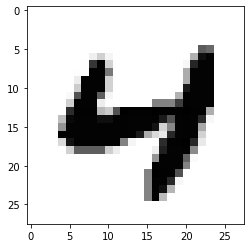

In [24]:
import matplotlib.pyplot as plt
import random

with torch.no_grad(): # Don't Calculate Gradient
    x_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    y_test = mnist_test.test_labels.to(device)

    pred = model(x_test)
    correct_pred = torch.argmax(pred, 1) == y_test
    acc = correct_pred.float().mean()
    print('Accuracy:',acc.item())

    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r].view(1, 1, 28, 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()